<a href="https://colab.research.google.com/github/PaprikaSteiger/CNN_GAN_tensorflow_vs_pytorch/blob/master/cnngan_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing a CNNGAN with pytroch

## 1. Import and Preprocessing
### a) Importing modules

In [2]:
# Load required packages - data handling & plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# Load required packages - deep learning 
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
print(f"tensorflow: {torch.__version__}")
import sys
print(f"python: {sys.version[:5]}")

tensorflow: 1.8.1+cu101
python: 3.7.1


### b) Importing the data

In [ ]:
# I exceeded my git LFS bandwidth limit for this month, thus the file cannot be loaded from git
train_data = pd.read_csv('https://media.githubusercontent.com/media/PaprikaSteiger/CNN_GAN_tensorflow_vs_pytorch/master/fashion-mnist_train.csv')

In [ ]:
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0


In [ ]:
train_images = train_data.iloc[:,1:]

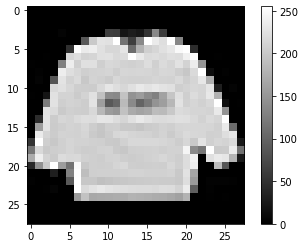

In [ ]:
plt.figure()
plt.imshow(train_images.values[0].reshape(28,28), cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

### c) Data preparation

In [ ]:
# use maximum normalization
train_images = train_images / np.float32(255)

In [ ]:
train_images.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.019608,0.0,0.0,0.000000,0.411765,0.360784,0.396078,0.419608,0.392157,0.517647,0.000000,0.000000,0.007843,0.015686,0.0,0.003922,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.588235,0.890196,...,0.827451,0.862745,0.839216,0.290196,0.000000,1.000000,0.870588,0.501961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.172549,0.047059,0.0,0.0,0.156863,0.525490,0.635294,0.749020,0.839216,0.639216,0.572549,0.647059,0.309804,0.000000,0.0,0.0,0.117647,0.168627,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.003922,0.007843,0.0,0.0,0.000000,0.0,0.0,0.447059,0.717647,0.439216,0.215686,0.090196,0.282353,0.400000,0.647059,0.627451,0.109804,0.000000,0.0,0.000000,0.003922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003922,0.0,0.0,0.094118,0.737255,0.639216,0.364706,0.533333,...,0.670588,0.976471,0.811765,0.772549,0.792157,0.176471,0.000000,0.011765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.003922,0.0,0.0,0.000000,0.086275,0.082353,0.098039,0.270588,0.203922,0.176471,0.290196,0.152941,0.011765,0.0,0.0,0.000000,0.000000,0.003922,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.180392,0.000000,0.082353,0.266667,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.098039,0.733333,0.741176,0.000000,...,0.901961,0.929412,0.898039,0.000000,0.000000,0.003922,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.266667,0.454902,0.439216,0.533333,0.576471,0.564706,0.474510,0.400000,0.247059,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0



## 2. Model specific data preparation (tensorflow)
## a) Load the data

In [ ]:
x_train_pt = torch.from_numpy(train_images.values.reshape((-1, 1, 28, 28)))

### b) Tensor view of the data

In [ ]:
x_train_pt.shape

torch.Size([60000, 1, 28, 28])

In [ ]:
seed.shape

torch.Size([28, 28])

In [ ]:
x_train_pt[0][0][5]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1843, 0.9882, 0.9176, 0.9333,
        0.8784, 0.8431, 0.8431, 0.8980, 0.4235, 0.7059, 0.8118, 0.8392, 0.8784,
        0.9059, 0.9765, 0.9961, 0.1765, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])

## 3. Model definition

In [15]:
def weights_init(m):
  if isinstance(m, nn.Linear):
      nn.init.uniform_(m.weight.data, -1,1)
      nn.init.zeros_(m.bias.data)
  if isinstance(m, nn.Conv2d):
      nn.init.uniform_(m.weight.data, -1, 1)
      nn.init.zeros_(m.bias.data)
  if isinstance(m, nn.ConvTranspose2d):
      nn.init.uniform_(m.weight.data, -1, 1)
      nn.init.zeros_(m.bias.data)

In [16]:
class Reshape(nn.Module):
    def __init__(self, channels, height, width):
        super(Reshape, self).__init__()
        self.shape = (channels, height, width)

    def forward(self, x):
        return x.view(self.shape)

### a.1) Generator

In [17]:
def generator_model():
    model = nn.Sequential()
    model.add_module("Conv2D1", nn.ConvTranspose2d(100, 64, 7, stride=1, padding=0, bias=True))
    #model.add_module("Reshape", Reshape(64, 7, 7))
    model.add_module("Batchnorm1", nn.BatchNorm2d(64))
    model.add_module("LeakyRelu1", nn.LeakyReLU())
    
    model.add_module("Conv2D2", nn.ConvTranspose2d(64, 32, (8,8), stride=(1,1), padding=0, bias=True))
    model.add_module("Batchnorm2", nn.BatchNorm2d(32))
    model.add_module("LeakyRelu2", nn.LeakyReLU())
    
    model.add_module("Conv2D3", nn.ConvTranspose2d(32, 1, (15,15), stride=1, padding=0, bias=True))
    model.add_module("Batchnorm3", nn.BatchNorm2d(1))
    model.add_module("Sigmoid1", nn.Sigmoid())
    return model
generator = generator_model()
#generator.eval()

###  a.2) Inspect the generator model

In [18]:
print(generator)

Sequential(
  (Conv2D1): ConvTranspose2d(100, 64, kernel_size=(7, 7), stride=(1, 1))
  (Batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (LeakyRelu1): LeakyReLU(negative_slope=0.01)
  (Conv2D2): ConvTranspose2d(64, 32, kernel_size=(8, 8), stride=(1, 1))
  (Batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (LeakyRelu2): LeakyReLU(negative_slope=0.01)
  (Conv2D3): ConvTranspose2d(32, 1, kernel_size=(15, 15), stride=(1, 1))
  (Batchnorm3): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Sigmoid1): Sigmoid()
)


In [19]:
generator.apply(weights_init)

Sequential(
  (Conv2D1): ConvTranspose2d(100, 64, kernel_size=(7, 7), stride=(1, 1))
  (Batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (LeakyRelu1): LeakyReLU(negative_slope=0.01)
  (Conv2D2): ConvTranspose2d(64, 32, kernel_size=(8, 8), stride=(1, 1))
  (Batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (LeakyRelu2): LeakyReLU(negative_slope=0.01)
  (Conv2D3): ConvTranspose2d(32, 1, kernel_size=(15, 15), stride=(1, 1))
  (Batchnorm3): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Sigmoid1): Sigmoid()
)

In [20]:
# generated image not trained
fake_im_not_trained = generator(torch.normal(0, 1, size=[1, 100, 1, 1]))
# check output shape of generator
fake_im_not_trained

tensor([[[[0.5230, 0.5461, 0.5439, 0.5035, 0.5890, 0.5871, 0.6494, 0.6215,
           0.6066, 0.5580, 0.6030, 0.5585, 0.5055, 0.5523, 0.5500, 0.4284,
           0.5115, 0.5150, 0.5896, 0.5708, 0.5741, 0.6088, 0.5289, 0.5867,
           0.5567, 0.5176, 0.5259, 0.5387],
          [0.5218, 0.5063, 0.5966, 0.5712, 0.4410, 0.5496, 0.6267, 0.5774,
           0.4489, 0.4983, 0.5680, 0.5629, 0.4645, 0.5490, 0.5110, 0.4709,
           0.5312, 0.6111, 0.6946, 0.5762, 0.6348, 0.6462, 0.5891, 0.5786,
           0.5524, 0.5204, 0.4827, 0.5296],
          [0.5179, 0.5240, 0.5300, 0.4851, 0.4820, 0.4725, 0.4746, 0.3542,
           0.4450, 0.3770, 0.6664, 0.4712, 0.4705, 0.5512, 0.5724, 0.3200,
           0.3519, 0.6568, 0.7151, 0.6054, 0.5777, 0.6353, 0.5958, 0.6671,
           0.5144, 0.5168, 0.5702, 0.5192],
          [0.5240, 0.5575, 0.4650, 0.4680, 0.3841, 0.4281, 0.2280, 0.3393,
           0.3656, 0.2630, 0.3052, 0.2906, 0.4946, 0.3898, 0.6375, 0.5036,
           0.2883, 0.6569, 0.6881, 0.4240, 

### a.3) Inspect the first convolutional layer

In [21]:
generator[0].weight[0]

tensor([[[ 0.7559,  0.2496, -0.2291,  ..., -0.6878, -0.3684,  0.7580],
         [ 0.2487,  0.6512,  0.7564,  ..., -0.8068, -0.6948, -0.3514],
         [-0.2338,  0.0330,  0.7632,  ...,  0.3809,  0.5917, -0.6294],
         ...,
         [-0.6728, -0.3124,  0.7846,  ...,  0.2179,  0.0990,  0.0612],
         [ 0.8130, -0.4786,  0.0728,  ...,  0.1687,  0.4673,  0.1248],
         [ 0.6978,  0.6183,  0.2969,  ..., -0.2764,  0.7022, -0.5189]],

        [[ 0.3306,  0.7710, -0.6513,  ..., -0.8253, -0.9600, -0.4408],
         [-0.9396,  0.7716,  0.0869,  ...,  0.8743, -0.8638, -0.2973],
         [-0.5154,  0.1877, -0.8550,  ..., -0.3349, -0.5136,  0.4769],
         ...,
         [ 0.9944, -0.9518, -0.6705,  ..., -0.8086,  0.2530,  0.2341],
         [ 0.3775,  0.5600,  0.3757,  ...,  0.1892,  0.6948, -0.3136],
         [ 0.0879,  0.8241, -0.9980,  ..., -0.2070,  0.7608,  0.1316]],

        [[ 0.6309,  0.8334, -0.1804,  ...,  0.2255,  0.3319, -0.5827],
         [ 0.2012, -0.1980, -0.1039,  ...,  0

In [22]:
generator[0].weight.shape

torch.Size([100, 64, 7, 7])

In [23]:
generator[0].bias

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True)

In [24]:
generator[0].bias.shape

torch.Size([64])

### b.1) Discriminator

In [25]:
def discriminator_model():
    model = nn.Sequential()
    model.add_module("Conv2D1", nn.Conv2d(1, 2, kernel_size=5, stride=1, padding=2))
    model.add_module("Pooling1", nn.AvgPool2d(kernel_size=2, stride=2))
    model.add_module("LeakyRelu1", nn.LeakyReLU())
    model.add_module("Dropout1", nn.Dropout(0.3))
    
    model.add_module("Conv2D2", nn.Conv2d(2, 2, kernel_size=5, stride=1, padding=2))
    model.add_module("LeakyRelu2", nn.LeakyReLU())
    
    model.add_module("Conv2D3", nn.Conv2d(2, 1, kernel_size=5, stride=1, padding=0))
    model.add_module("LeakyRelu3", nn.LeakyReLU())
    
    model.add_module("Flatten1", nn.Flatten())
    
    model.add_module("Dense1", nn.Linear(100,100))
    model.add_module("LeakyRelu4", nn.LeakyReLU())
    
    model.add_module("Dense2", nn.Linear(100,64))
    model.add_module("Tanh", nn.Tanh())
    
    model.add_module("Dense3", nn.Linear(64,1))
    model.add_module("Sigmoid", nn.Sigmoid())
    return model
discriminator = discriminator_model()

### b.2) Inspect the discriminator model

In [ ]:
print(discriminator)
discriminator(fake_im_not_trained)

Sequential(
  (Conv2D1): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (Pooling1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (LeakyRelu1): LeakyReLU(negative_slope=0.01)
  (Dropout1): Dropout(p=0.3, inplace=False)
  (Conv2D2): Conv2d(2, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (LeakyRelu2): LeakyReLU(negative_slope=0.01)
  (Conv2D3): Conv2d(2, 1, kernel_size=(5, 5), stride=(1, 1))
  (LeakyRelu3): LeakyReLU(negative_slope=0.01)
  (Flatten1): Flatten(start_dim=1, end_dim=-1)
  (Dense1): Linear(in_features=100, out_features=100, bias=True)
  (LeakyRelu4): LeakyReLU(negative_slope=0.01)
  (Dense2): Linear(in_features=100, out_features=64, bias=True)
  (Tanh): Tanh()
  (Dense3): Linear(in_features=64, out_features=1, bias=True)
  (Sigmoid): Sigmoid()
)


tensor([[0.4763]], grad_fn=<SigmoidBackward>)

In [ ]:
discriminator.apply(weights_init)

Sequential(
  (Conv2D1): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (Pooling1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (LeakyRelu1): LeakyReLU(negative_slope=0.01)
  (Dropout1): Dropout(p=0.3, inplace=False)
  (Conv2D2): Conv2d(2, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (LeakyRelu2): LeakyReLU(negative_slope=0.01)
  (Conv2D3): Conv2d(2, 1, kernel_size=(5, 5), stride=(1, 1))
  (LeakyRelu3): LeakyReLU(negative_slope=0.01)
  (Flatten1): Flatten(start_dim=1, end_dim=-1)
  (Dense1): Linear(in_features=100, out_features=100, bias=True)
  (LeakyRelu4): LeakyReLU(negative_slope=0.01)
  (Dense2): Linear(in_features=100, out_features=64, bias=True)
  (Tanh): Tanh()
  (Dense3): Linear(in_features=64, out_features=1, bias=True)
  (Sigmoid): Sigmoid()
)

### b.3) Inspect the first convolutional layer

In [ ]:
discriminator[0].weight[0].type()

'torch.FloatTensor'

In [ ]:
discriminator[0].weight.shape

torch.Size([2, 1, 5, 5])

In [ ]:
discriminator[0].bias

Parameter containing:
tensor([0., 0.], requires_grad=True)

In [ ]:
discriminator[0].bias.shape

torch.Size([2])

## 4. Loss & Optimizer

### 4.a) Generator loss

In [ ]:
cross_entropy = nn.BCEWithLogitsLoss()
def generator_loss(fake_output):
    return cross_entropy(torch.ones_like(fake_output), fake_output)

### 4.b) Discriminator loss

In [ ]:
def real_discriminator_loss(real_output):
    return  cross_entropy(torch.ones_like(real_output), real_output)

def fake_discriminator_loss(fake_output):
    return cross_entropy(torch.zeros_like(fake_output), fake_output)

## 4.c) Optimizers

In [ ]:
generator_optimizer = optim.Adam(generator.parameters(), lr=1e-2)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=1e-2)

def correct_classification(y_true, y_prob):
    assert y_true.size() == y_prob.size()
    y_prob = (y_prob > 0.5).float()
    return (y_true == y_prob).sum().item()

## 5. Training

In [6]:
# This annotation causes the function to be "compiled".
#@tf.function
def train_step_pt(generator, discriminator, generator_optimizer, discriminator_optimizer, batch_size = 100):
    gen_loss_tot = []
    disc_loss_tot = []
    disc_acc_real_tot = 0
    disc_acc_fake_tot = 0
    generator.train()
    discriminator.train()
    for beg_i in range(0, x_train_pt.shape[0], batch_size):
        x_train_batch_pt = x_train_pt[beg_i:beg_i + batch_size]

        x_fake_batch_pt = torch.normal(0, 1, size=[batch_size, 100, 1, 1])
        
        discriminator_optimizer.zero_grad()
        real_output = discriminator(x_train_batch_pt.float()).view(-1)
        disc_loss_real = real_discriminator_loss(real_output)
        disc_loss_real.backward()
        
        generated_images = generator(x_fake_batch_pt)
        fake_output = discriminator(generated_images.detach()).view(-1)
        disc_loss_fake = fake_discriminator_loss(fake_output)
        disc_loss_fake.backward()
        err = disc_loss_fake + disc_loss_real
        discriminator_optimizer.step()
        
        # optimize generator
        generator_optimizer.zero_grad()
        fake_output = discriminator(generated_images.detach()).view(-1)
        gen_loss = generator_loss(fake_output)
        gen_loss.backward()
        generator_optimizer.step()
        
        gen_loss_tot.append(gen_loss.mean().item())
        disc_loss_tot.append(err.mean().item())
        disc_acc_real_tot += correct_classification(torch.ones_like(real_output), real_output)
        disc_acc_fake_tot += correct_classification(torch.zeros_like(fake_output), fake_output)

    disc_acc_real_tot = disc_acc_real_tot/x_train_pt.size(0)
    disc_acc_fake_tot = disc_acc_fake_tot/x_train_pt.size(0)
    print([disc_acc_real_tot, disc_acc_fake_tot])
    disc_acc_tot = np.mean([disc_acc_real_tot, disc_acc_fake_tot])
    return gen_loss_tot, disc_loss_tot, disc_acc_tot

In [ ]:
train_losses_generator_pt = []
train_losses_discriminator_pt = []
train_acc_discriminator_pt = []
epochs = 15
start = time.time()
for epoch in range(epochs):
    gen_loss, disc_loss, disc_acc = train_step_pt(generator, discriminator, generator_optimizer, discriminator_optimizer)
    gen_loss = np.mean(gen_loss)
    disc_loss = np.mean(disc_loss)
    train_losses_generator_pt.append(gen_loss)
    train_losses_discriminator_pt.append(disc_loss)
    train_acc_discriminator_pt.append(disc_acc*100)


    template = ("Epoch {}, Loss_Generator: {}, Loss_Discriminator: {}, Discriminator_Accuracy: {}")
    print(template.format(epoch+1, gen_loss, disc_loss, disc_acc*100))
end = time.time()
print(f"Total training time{(end - start)/60.0}")

[0.9985, 0.0]
Epoch 1, Loss_Generator: 0.3137556545933088, Loss_Discriminator: 1.0079493055740991, Discriminator_Accuracy: 49.925000000000004
[1.0, 0.0]
Epoch 2, Loss_Generator: 0.31326165795326233, Loss_Discriminator: 1.0064088106155396, Discriminator_Accuracy: 50.0
[1.0, 0.0]
Epoch 3, Loss_Generator: 0.31326165795326233, Loss_Discriminator: 1.0064088106155396, Discriminator_Accuracy: 50.0
[1.0, 0.0]
Epoch 4, Loss_Generator: 0.31326165795326233, Loss_Discriminator: 1.0064088106155396, Discriminator_Accuracy: 50.0
[1.0, 0.0]
Epoch 5, Loss_Generator: 0.31326165795326233, Loss_Discriminator: 1.0064088106155396, Discriminator_Accuracy: 50.0
[1.0, 0.0]
Epoch 6, Loss_Generator: 0.31326165795326233, Loss_Discriminator: 1.0064088106155396, Discriminator_Accuracy: 50.0
[1.0, 0.0]
Epoch 7, Loss_Generator: 0.31326165795326233, Loss_Discriminator: 1.0064088106155396, Discriminator_Accuracy: 50.0


KeyboardInterrupt: ignored

In [ ]:
print(f"Total training time{(end - start)/60.0}")

### b) Training progress

In [ ]:
plt.figure(figsize=(16,10))
plt.plot(train_acc_discriminator_pt)
plt.title('discriminator accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['discriminator_train'], loc='upper right')
plt.show()

In [ ]:
plt.figure(figsize=(16,10))
plt.plot(train_losses_generator_pt)
plt.plot(train_losses_discriminator_pt)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['generator', 'discriminator'], loc='upper right')
plt.show()

### c1) Generator output before training

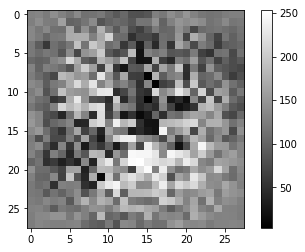

In [12]:

fake_im_not_trained = fake_im_not_trained.detach().numpy() * 255
fake_im_not_trained = fake_im_not_trained.reshape((28,28))
plt.figure()
plt.imshow(fake_im_not_trained, cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

### c2) Generator output after training

In [ ]:
seed2 = torch.normal(0, 1, size=[1, 100, 1, 1])
generator.train(False)
fake_im = generator(seed2)
fake_im = fake_im.detach().numpy() * 255
fake_im = fake_im.reshape((28,28))
plt.figure()
plt.imshow(fake_im, cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

## 6. References
The presented model is based on a combination of two tutorials for deep cnn-gans:
1) https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

2) https://www.tensorflow.org/tutorials/generative/dcgan